In [1]:
using PyPlot
using DataFrames
using CSV
import Statistics

In [2]:
include("./src/loop_function.jl")
include("./src/tmat.jl")
# include("./src/tmat_up_to_nlo.jl")
include("./src/par.jl")
include("./src/subtraction_cons.jl")

subtraction_cons_tuple (generic function with 1 method)

In [3]:
import PyCall
iminuit = PyCall.pyimport("iminuit");

In [4]:
par_phy_channel = par_physical_channel()
# par_phy_channel[:decons] = 106.0

Dict{Symbol, Any} with 5 entries:
  :threshold  => [1431.95, 1328.94, 1327.62, 1437.22, 1337.02, 1250.66]
  :mch        => [(493.68, 938.272), (139.57, 1189.37), (134.977, 1192.64), (49…
  :mB         => [938.272, 939.565, 1115.68, 1197.45, 1192.64, 1189.37]
  :meson_mass => (139.57, 134.977, 139.57, 497.65, 493.68)
  :decons     => 100.69

In [6]:
function plot_cross_section(ax, df; kwargs...)
    mKbarn = 1437.22
    ax.errorbar(df.Ecm, df.sigma, yerr=df.dsigma, fmt="s"; kwargs...)
    ax.set_ylim(0, maximum(df.sigma + df.dsigma))
    ax.vlines(mKbarn, 0, maximum(df.sigma + df.dsigma), ls="--", color="k")
    ax.legend()
end;

In [7]:
b = (-0.664609603537589, 0.062434962905761365, -0.35384103271852047)
d = (-0.3595489872519527, 0.020386885826743775, -0.1405760338940346, -0.5771420439532574)
CC = lecs_cij()
DD = lec_bi(par_phy_channel, b)
LL = lec_di(d)
qmax_nlo = 709.8420762525412
mu=630e0
anlo_phy_channel = Tuple(subtraction_cons(par_phy_channel[:mch][i], mu, qmax_nlo) for i in 1:6);

In [8]:
data_path = "./lambda1405_data/lambda1405_data/";

Kmp_to_Kbar0n = CSV.read(data_path * "Kmp_to_Kbar0n.csv", DataFrame)
Kmp_to_Kmp = CSV.read(data_path * "Kmp_to_Kmp.csv", DataFrame)
Kmp_to_Lampi0 = CSV.read(data_path * "Kmp_to_Lampi0.csv", DataFrame)
Kmp_to_Sig0pi0 = CSV.read(data_path * "Kmp_to_Sig0pi0.csv", DataFrame)
Kmp_to_Sigmpip = CSV.read(data_path * "Kmp_to_Sigmpip.csv", DataFrame)
Kmp_to_Sigppim = CSV.read(data_path * "Kmp_to_Sigppim.csv", DataFrame);

mKbarn = 1437.22
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Kbar0n)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Kmp)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Lampi0)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Sig0pi0)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Sigmpip)
# filter!(df -> df.Ecm >= mKbarn, Kmp_to_Sigppim);


# filter!(df -> 1500>= df.Ecm >= mKbarn, Kmp_to_Kbar0n)
# filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Kmp)
# filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Lampi0)
# filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Sig0pi0)
# filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Sigmpip)
# filter!(df -> 1500>=df.Ecm >= mKbarn, Kmp_to_Sigppim);

w1 = Kmp_to_Kmp.Ecm
w2 = Kmp_to_Sigppim.Ecm
w3 = Kmp_to_Sig0pi0.Ecm
w4 = Kmp_to_Kbar0n.Ecm
w5 = Kmp_to_Sigmpip.Ecm
w6 = Kmp_to_Lampi0.Ecm

s1 = Kmp_to_Kmp.sigma
s2 = Kmp_to_Sigppim.sigma
s3 = Kmp_to_Sig0pi0.sigma
s4 = Kmp_to_Kbar0n.sigma
s5 = Kmp_to_Sigmpip.sigma
s6 = Kmp_to_Lampi0.sigma

ds1 = Kmp_to_Kmp.dsigma
ds2 = Kmp_to_Sigppim.dsigma
ds3 = Kmp_to_Sig0pi0.dsigma
ds4 = Kmp_to_Kbar0n.dsigma
ds5 = Kmp_to_Sigmpip.dsigma
ds6 = Kmp_to_Lampi0.dsigma;

ww = push!([], w1..., w2..., w3..., w4..., w5..., w6...)
ss = push!([], s1..., s2..., s3..., s4..., s5..., s6...)
dss = push!([], ds1..., ds2..., ds3..., ds4..., ds5..., ds6...);
len = length(ww)

350

In [10]:
function cost_fun(free_par)

    lam = free_par[1]
    alo = Tuple(subtraction_cons(par_phy_channel[:mch][i], mu, lam) for i in 1:6)
   

    ss1 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch11), w1)
    ss2 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch12), w2)
    ss3 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch13), w3)
    ss4 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch14), w4)
    ss5 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch15), w5)
    ss6 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch16), w6)
    ss_th = push!([], ss1..., ss2..., ss3..., ss4..., ss5..., ss6...)
    y = (ss_th - ss) ./ dss
    
    return y' * y
end

cost_fun (generic function with 1 method)

In [11]:
free_par = [669.0584858742495]#[-0.3595489872519527, 0.020386885826743775, -0.1405760338940346, -0.5771420439532574, 500.8420762525412]
name = [:lam]
fit = iminuit.Minuit(x -> cost_fun(x), free_par, name=name)
# fit.limits = [(-1, 1), (-1, 1), (-1, 1), (-1, 1), (620e0, 1200e0)]
# fit.fixed = true
# fit.fixed[5] = true
# fit.fixed[2]=true
fit

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,lam,669,7,,,,,


In [12]:
fit.migrad()
println("The reduced χ^2 is $(fit.fval / (len - fit.nfit))")
fit

The reduced χ^2 is 63.06230055858878


PyObject <FMin algorithm='Migrad' edm=3.29703886853947e-08 edm_goal=0.0002 errordef=1.0 fval=22008.742894947485 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=20 ngrad=0 reduced_chi2=nan time=2.8024889290099964>
(Param(number=0, name='lam', value=624.1094045102051, error=4.760926013237574, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None),)
[[22.6664165]]

In [13]:
val = Tuple(fit.values)

(624.1094045102051,)

In [14]:

lam = val[1]
alo = Tuple(subtraction_cons(par_phy_channel[:mch][i], mu, lam) for i in 1:6)


(-1.899900683743504, -2.1843973997094857, -2.1898520313130745, -1.9012789103373826, -2.191466691750339, -2.121908937615463)

In [15]:
alo

(-1.899900683743504, -2.1843973997094857, -2.1898520313130745, -1.9012789103373826, -2.191466691750339, -2.121908937615463)

In [16]:
w = mKbarn:0.1:1560e0
sc1 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch11), w);
sc2 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch12), w);
sc3 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch13), w);
sc4 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch14), w);
sc5 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch15), w);
sc6 = map(x -> dist_lo(x, par_phy_channel, CC, alo, :ch16), w);

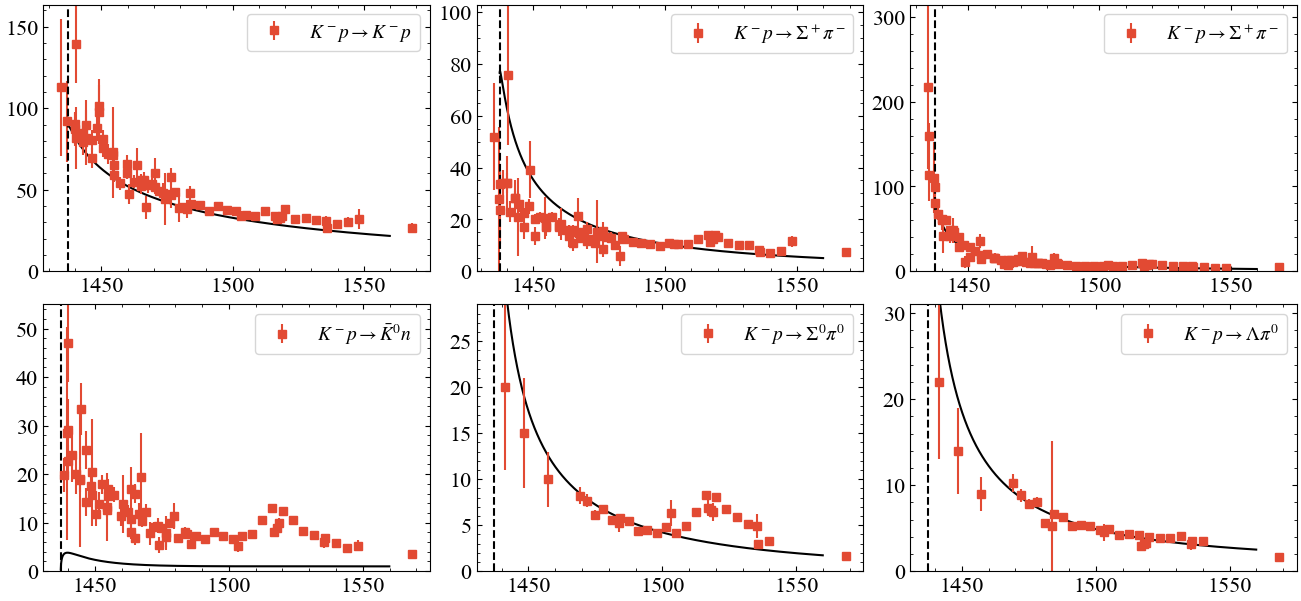

In [20]:
fig, ax = PyPlot.subplots(2, 3, layout="constrained", figsize=(13, 6))

ax[1, 1].plot(w, sc1, c="k")
ax[1, 2].plot(w, sc2, c="k")
ax[1, 3].plot(w, sc5, c="k")


ax[2, 1].plot(w, sc4, c="k")
ax[2, 2].plot(w, sc3, c="k")
ax[2, 3].plot(w, sc6, c="k")


plot_cross_section(ax[1, 1], Kmp_to_Kmp, label=L"K^- p \to K^- p") # 11
plot_cross_section(ax[1, 2], Kmp_to_Sigppim, label=L"K^- p \to \Sigma^+\pi^-") # 12
plot_cross_section(ax[1, 3], Kmp_to_Sigmpip, label=L"K^- p \to \Sigma^+\pi^-") # 15

plot_cross_section(ax[2, 1], Kmp_to_Kbar0n, label=L"K^- p \to \bar{K}^0 n") # 14
plot_cross_section(ax[2, 2], Kmp_to_Sig0pi0, label=L"K^- p \to \Sigma^0 \pi^0") # 13
plot_cross_section(ax[2, 3], Kmp_to_Lampi0, label=L"K^- p \to \Lambda\pi^0") # 16



gcf()